In [2]:
import os, random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import functional as TF
from torchvision.models import ResNet34_Weights

import matplotlib.pyplot as plt


### **Setup: Environment and Configuration**
This block handles the initial setup of the environment, including mounting Google Drive, defining file paths, and setting global training hyperparameters.

* **`Paths`**: Mounts Google Drive and sets up `pathlib` paths for the project directory, raw images, masks, and output folders to ensure organized file access.
* **`Train config`**: Defines the global hyperparameters (Batch Size, Learning Rate, Epochs, Image Size) that control the training process.
* **`set_seed`**: Fixes the random seed across all libraries (Python, NumPy, PyTorch) to ensure that the experiments are reproducible and yield the same results every time they are run.
* **`DEVICE`**: Automatically detects and selects the best available hardware accelerator (CUDA for Nvidia GPUs, MPS for Mac, or CPU).

In [3]:
# -----------------------
# Paths
# -----------------------
from google.colab import drive



drive.mount("/content/drive")

# Move CWD to the project folder
PROJECT_DIR = Path("/content/drive/MyDrive/CornealSeg")
%cd "{PROJECT_DIR}"


DATA_ROOT = Path("data")
CSV_PATH  = DATA_ROOT / "outputs" / "dataset_index.csv"
RAW_DIR   = DATA_ROOT / "rawImages"
MASK_DIR  = DATA_ROOT / "ulcerLabels"
COR_DIR   = DATA_ROOT / "corneaLabels"
OUT_DIR   = DATA_ROOT / "outputs"

print("CWD:", Path.cwd())
print("CSV_PATH exists:", CSV_PATH.exists())


# -----------------------
# Train config
# -----------------------
SEED = 42
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 15
LR = 2e-4
WD = 1e-4
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
print("device:", DEVICE)


Mounted at /content/drive
/content/drive/MyDrive/CornealSeg
CWD: /content/drive/MyDrive/CornealSeg
CSV_PATH exists: True
device: cuda


### **Utilities: File Handling and Mask Generation**
This block contains helper functions to manage file paths and convert raw images into binary masks for training.

* **`find_image_path`**: Locates the specific image file on the disk (checking for extensions like jpg/png) based on its ID.
* **`load_gray`**: Loads an image file and converts it to a grayscale NumPy array.
* **`ulcer_mask01_from_gray`**: Converts the grayscale ground truth image into a binary mask (0 or 1) representing the ulcer.
* **`cornea_mask01_from_gray`**: Smartly detects the cornea region to create a binary Region of Interest (ROI) mask, handling different lighting conditions.

In [4]:
# =========================================
#  Utilities (paths + masks + ROI masking)
# =========================================
def find_image_path(img_id: int) -> Path:
    for ext in (".png", ".jpg", ".jpeg"):
        p = RAW_DIR / f"{img_id}{ext}"
        if p.exists():
            return p
    raise FileNotFoundError(f"Missing image for id={img_id} in {RAW_DIR}")

def load_gray(path: Path) -> np.ndarray:
    return np.array(Image.open(path).convert("L"))

def ulcer_mask01_from_gray(gray: np.ndarray, thr=127) -> np.ndarray:
    # ulcer is BLACK => positive = pixel < thr
    return (gray < thr).astype(np.uint8)

def cornea_mask01_from_gray(gray: np.ndarray, thr=127) -> np.ndarray:
    """
    Returns cornea mask as {0,1}.
    Handles both encodings:
      - cornea white on black
      - cornea black on white
    We decide by looking at center pixel (cornea is usually centered).
    """
    h, w = gray.shape
    center_is_white = gray[h//2, w//2] > thr
    if center_is_white:
        return (gray > thr).astype(np.uint8)   # cornea = white region
    else:
        return (gray < thr).astype(np.uint8)   # cornea = black region


### **Dataset Class: Loading and Preprocessing**
This block defines the custom PyTorch `Dataset` class, which handles data loading, resizing, ROI masking, and augmentation.

* **`__init__`**: Initializes the dataset by filtering the dataframe for the specific split (train/test/val) and setting configuration flags.
* **`__len__`**: Returns the total number of samples in the dataset.
* **`__getitem__`**: The core function that loads a specific image and mask, applies resizing, executes data augmentation (if training), applies the ROI mask (if requested), and returns the final tensors.

In [5]:
# =========================================
#  Dataset (train aug only) + Resize
# ROI here means: mask outside cornea (not crop)
# =========================================
class UlcerSegDataset(Dataset):
    def __init__(self, df, split, use_roi=False, train_aug=False):
        self.df = df[df["split"] == split].copy().reset_index(drop=True)
        self.use_roi = use_roi
        self.train_aug = train_aug

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row["id"])

        img_path = find_image_path(img_id)
        ulcer_path = MASK_DIR / f"{img_id}.png"

        img = Image.open(img_path).convert("RGB")

        ulcer_gray = load_gray(ulcer_path)
        ulcer01 = ulcer_mask01_from_gray(ulcer_gray)  # (H,W) in {0,1}

        cor01 = None
        if self.use_roi:
            cor_path = COR_DIR / f"{img_id}.png"
            cor_gray = load_gray(cor_path)
            cor01 = cornea_mask01_from_gray(cor_gray)  # (H,W) in {0,1}
            ulcer01 = (ulcer01 & cor01).astype(np.uint8)  # safety

        # ---------
        # Resize
        # ---------
        img = TF.resize(img, [IMG_SIZE, IMG_SIZE], interpolation=TF.InterpolationMode.BILINEAR)

        ulcer_img = Image.fromarray((ulcer01 * 255).astype(np.uint8))
        ulcer_img = TF.resize(ulcer_img, [IMG_SIZE, IMG_SIZE], interpolation=TF.InterpolationMode.NEAREST)
        ulcer = (np.array(ulcer_img) > 127).astype(np.float32)  # 0/1

        if self.use_roi:
            cor_img = Image.fromarray((cor01 * 255).astype(np.uint8))
            cor_img = TF.resize(cor_img, [IMG_SIZE, IMG_SIZE], interpolation=TF.InterpolationMode.NEAREST)
            cor = (np.array(cor_img) > 127).astype(np.float32)   # 0/1
            ulcer = ulcer * cor  # keep GT inside cornea only
        else:
            cor = None

        # ---------
        # Train augmentations (shared geometry)
        # ---------
        if self.train_aug:
            if random.random() < 0.5:
                img = TF.hflip(img)
                ulcer = np.fliplr(ulcer).copy()
                if cor is not None:
                    cor = np.fliplr(cor).copy()

            angle = random.uniform(-12, 12)
            img = TF.rotate(img, angle, interpolation=TF.InterpolationMode.BILINEAR)

            m = Image.fromarray((ulcer * 255).astype(np.uint8))
            m = TF.rotate(m, angle, interpolation=TF.InterpolationMode.NEAREST)
            ulcer = (np.array(m) > 127).astype(np.float32)

            if cor is not None:
                c = Image.fromarray((cor * 255).astype(np.uint8))
                c = TF.rotate(c, angle, interpolation=TF.InterpolationMode.NEAREST)
                cor = (np.array(c) > 127).astype(np.float32)
                ulcer = ulcer * cor  # safety after rotate

            # color-only
            img = TF.adjust_brightness(img, 1.0 + random.uniform(-0.12, 0.12))
            img = TF.adjust_contrast(img,   1.0 + random.uniform(-0.12, 0.12))

        # ---------
        # To tensor + apply ROI masking on image
        # ---------
        img_t = TF.to_tensor(img)  # [0,1]
        if cor is not None:
            cor_t = torch.from_numpy(cor).unsqueeze(0)  # (1,H,W)
            img_t = img_t * cor_t  # broadcast to 3 channels

        img_t = TF.normalize(img_t, [0.5]*3, [0.5]*3)
        msk_t = torch.from_numpy(ulcer).unsqueeze(0)

        return img_t, msk_t


### **Model Architecture: U-Net with ResNet34 Encoder**
This block implements the U-Net architecture , replacing the standard encoder with a pre-trained ResNet34 for better feature extraction.

* **`ConvBlock`**: A basic building block consisting of two convolutional layers with Batch Normalization and ReLU activation.
* **`UpBlock`**: The decoder block that upsamples the feature map and merges it with the corresponding "skip connection" from the encoder to preserve spatial details.
* **`UNetResNet34`**: The main model class that assembles the ResNet34 encoder (chopping off the classification head) and connects it to the custom decoder.

In [6]:
# =========================================
#  Model (U-Net decoder on ResNet34 encoder)
# NOTE: output is 128x128, we will upsample in the loops.
# =========================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvBlock(out_ch + skip_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class UNetResNet34(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        weights = ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        base = torchvision.models.resnet34(weights=weights)

        self.enc0 = nn.Sequential(base.conv1, base.bn1, base.relu)  # /2
        self.pool = base.maxpool                                   # /4
        self.enc1 = base.layer1                                     # /4
        self.enc2 = base.layer2                                     # /8
        self.enc3 = base.layer3                                     # /16
        self.enc4 = base.layer4                                     # /32

        self.center = ConvBlock(512, 512)
        self.up4 = UpBlock(512, 256, 256)
        self.up3 = UpBlock(256, 128, 128)
        self.up2 = UpBlock(128, 64, 64)
        self.up1 = UpBlock(64, 64, 32)
        self.head = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        x0 = self.enc0(x)            # /2
        x1 = self.enc1(self.pool(x0))# /4
        x2 = self.enc2(x1)           # /8
        x3 = self.enc3(x2)           # /16
        x4 = self.enc4(x3)           # /32

        c  = self.center(x4)
        d4 = self.up4(c,  x3)
        d3 = self.up3(d4, x2)
        d2 = self.up2(d3, x1)
        d1 = self.up1(d2, x0)
        return self.head(d1)         # logits (usually 128x128 if IMG_SIZE=256)


### **Loss Function and Evaluation Metrics**
This block defines the mathematical formulas used to evaluate the model's performance and calculate the error (loss) for training.

* **`dice_iou_from_logits`**: Calculates the **Dice Score** and **IoU** (Intersection over Union) for reporting accuracy to the user (uses hard thresholding).
* **`dice_loss_from_logits`**: Calculates the differentiable **Dice Loss** used by the optimizer to improve shape overlap during training.
* **`total_loss`**: The final objective function, which is a weighted average of Binary Cross Entropy (pixel accuracy) and Dice Loss (shape accuracy).

In [7]:
# =========================================
#  Loss + Metrics (Dice + IoU)
# =========================================
def dice_iou_from_logits(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    inter = (preds * targets).sum(dim=(2,3))
    union = (preds + targets - preds*targets).sum(dim=(2,3))

    dice = (2*inter + eps) / (preds.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + eps)
    iou  = (inter + eps) / (union + eps)
    return dice.mean().item(), iou.mean().item()

def dice_loss_from_logits(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    inter = (probs * targets).sum(dim=(2,3))
    denom = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    dice = (2*inter + eps) / (denom + eps)
    return 1 - dice.mean()

bce = nn.BCEWithLogitsLoss()

def total_loss(logits, targets):
    return 0.5*bce(logits, targets) + 0.5*dice_loss_from_logits(logits, targets)


### **Data Setup**
This block reads the CSV file containing the dataset index and verifies that the necessary columns (`id`, `split`) exist.

In [8]:
# =========================================
# BLOCK 8 - Load CSV + base loaders
# =========================================
df = pd.read_csv(CSV_PATH)
assert {"id","split"}.issubset(df.columns), "CSV must include: id, split"

print(df["split"].value_counts())


split
train    247
test      54
val       53
Name: count, dtype: int64


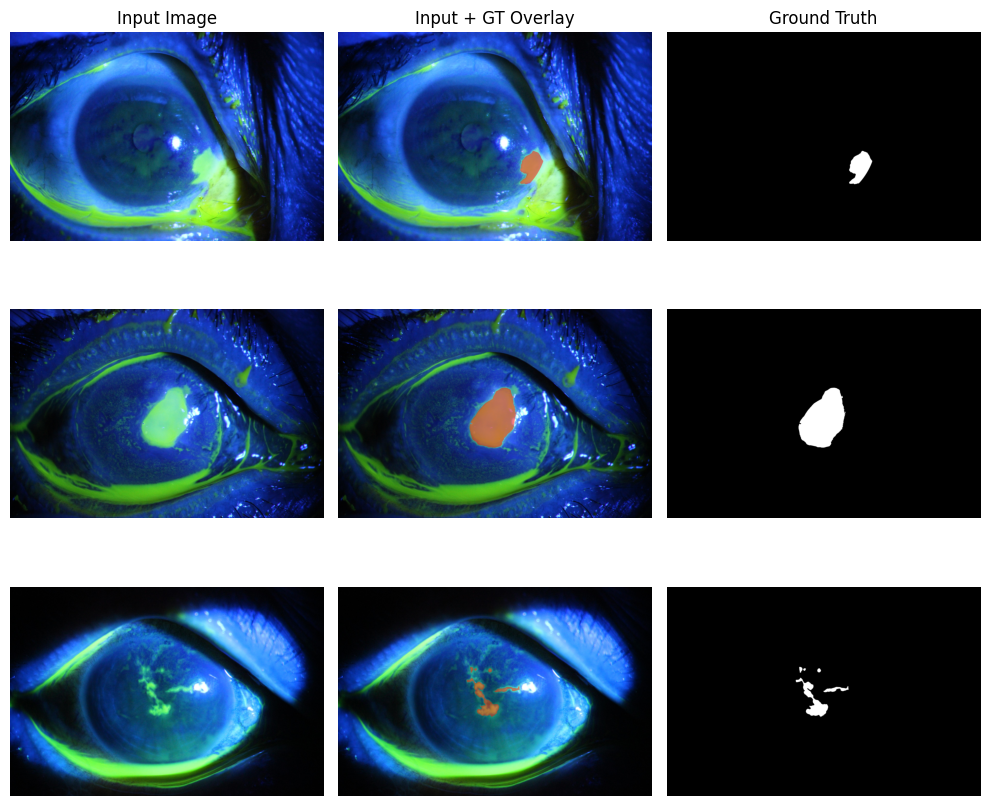

In [23]:
# =========================================
#  Data Visualization - Sample Images
# =========================================
def show_sample_images(n=3):
    """Display sample images: Original, with overlay, and GT mask."""
    sample_ids = df[df["split"] == "train"]["id"].sample(n, random_state=42).tolist()

    fig, axes = plt.subplots(n, 3, figsize=(10, 3*n))

    for i, img_id in enumerate(sample_ids):
        # Load raw image
        img_path = find_image_path(img_id)
        img = np.array(Image.open(img_path).convert("RGB"))

        # Load ulcer mask
        ulcer_path = MASK_DIR / f"{img_id}.png"
        ulcer_gray = load_gray(ulcer_path)
        ulcer_mask = ulcer_mask01_from_gray(ulcer_gray)

        # Create red overlay on entire ulcer region
        overlay = img.copy()
        overlay[ulcer_mask == 1] = [255, 0, 0]  # Red fill
        blended = (0.5 * img + 0.5 * overlay).astype(np.uint8)

        # Plot - Column 1: Original
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Input Image" if i == 0 else "")
        axes[i, 0].axis("off")

        # Plot - Column 2: Image + GT Overlay
        axes[i, 1].imshow(blended)
        axes[i, 1].set_title("Input + GT Overlay" if i == 0 else "")
        axes[i, 1].axis("off")

        # Plot - Column 3: GT Mask
        axes[i, 2].imshow(ulcer_mask, cmap="gray")
        axes[i, 2].set_title("Ground Truth" if i == 0 else "")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Show examples
show_sample_images(3)

### **Evaluation Helper Function**
This block defines a utility function to evaluate the model on a specific dataset (Validation or Test) without training it.

* **`eval_loader`**: Iterates through a Data Loader, generates predictions, resizes them to match the original resolution, calculates the average Loss, Dice, and IoU, and returns the results.

In [9]:
# =========================================
#  Eval function
# =========================================
@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    dices, ious, losses = [], [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = model(x)
        logits = F.interpolate(logits, size=y.shape[-2:], mode="bilinear", align_corners=False)

        losses.append(total_loss(logits, y).item())
        d, i = dice_iou_from_logits(logits, y)
        dices.append(d); ious.append(i)

    return float(np.mean(losses)), float(np.mean(dices)), float(np.mean(ious))


### **Training Experiment Engine**
This block contains the main function that manages the entire training lifecycle, from initialization to testing.

* **`train_experiment`**: Sets up the model and optimizer, runs the training loop for the specified number of epochs, handles validation and learning rate scheduling, saves the best model checkpoint, and finally evaluates it on the test set.

In [10]:
# =========================================
#  Train experiment (returns history for plots)
# =========================================
def train_experiment(name, pretrained=False, use_roi=False):
    model = UNetResNet34(pretrained=pretrained).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2)

    tr = DataLoader(UlcerSegDataset(df, "train", use_roi=use_roi, train_aug=True),
                    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    va = DataLoader(UlcerSegDataset(df, "val", use_roi=use_roi, train_aug=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    te = DataLoader(UlcerSegDataset(df, "test", use_roi=use_roi, train_aug=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    best_dice = -1.0
    best_path = OUT_DIR / f"{name}_best.pt"
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    history = {"epoch": [], "train_loss": [], "val_loss": [], "val_dice": [], "val_iou": []}

    for epoch in range(1, EPOCHS + 1):
        model.train()
        tr_losses = []

        for x, y in tr:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()

            logits = model(x)
            logits = F.interpolate(logits, size=y.shape[-2:], mode="bilinear", align_corners=False)

            loss = total_loss(logits, y)
            loss.backward()
            opt.step()
            tr_losses.append(loss.item())

        v_loss, v_dice, v_iou = eval_loader(model, va)
        sched.step(v_dice)

        if v_dice > best_dice:
            best_dice = v_dice
            torch.save({"model": model.state_dict(), "epoch": epoch, "val_dice": v_dice}, best_path)

        history["epoch"].append(epoch)
        history["train_loss"].append(float(np.mean(tr_losses)))
        history["val_loss"].append(float(v_loss))
        history["val_dice"].append(float(v_dice))
        history["val_iou"].append(float(v_iou))

        print(f"[{name}] ep {epoch:02d} | train_loss {np.mean(tr_losses):.4f} | val_loss {v_loss:.4f} | val_dice {v_dice:.4f} | val_iou {v_iou:.4f}")

    ckpt = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ckpt["model"])
    t_loss, t_dice, t_iou = eval_loader(model, te)
    print(f"[{name}] BEST@ep {ckpt['epoch']} | TEST dice={t_dice:.4f} iou={t_iou:.4f}")

    return model, (t_dice, t_iou), best_path, history


### **Execution: Running the Experiments**
This block executes the three different experimental setups required for the project comparison:
1.  **Scratch**: Training from random weights without ROI masking.
2.  **Pretrained**: Training with Transfer Learning (ImageNet weights) without ROI masking.
3.  **Pretrained + ROI**: Training with Transfer Learning AND the Region of Interest mask (the proposed method).

In [11]:
# =========================================
# BLOCK 11 - Run experiments
# =========================================
model_scratch, res_scratch, _, hist_scratch = train_experiment("A_scratch_noROI",    pretrained=False, use_roi=False)
model_pretr,   res_pretr,   _, hist_pretr   = train_experiment("B_pretrained_noROI", pretrained=True,  use_roi=False)
model_roi,     res_roi,     _, hist_roi     = train_experiment("C_pretrained_ROI",   pretrained=True,  use_roi=True)

print("Scratch:", res_scratch)
print("Pretrained:", res_pretr)
print("Pretrained+ROI:", res_roi)


[A_scratch_noROI] ep 01 | train_loss 0.7504 | val_loss 0.7156 | val_dice 0.4535 | val_iou 0.3590
[A_scratch_noROI] ep 02 | train_loss 0.6802 | val_loss 0.7338 | val_dice 0.3093 | val_iou 0.2017
[A_scratch_noROI] ep 03 | train_loss 0.6540 | val_loss 0.6430 | val_dice 0.5610 | val_iou 0.4555
[A_scratch_noROI] ep 04 | train_loss 0.6443 | val_loss 0.6212 | val_dice 0.5599 | val_iou 0.4554
[A_scratch_noROI] ep 05 | train_loss 0.6277 | val_loss 0.5996 | val_dice 0.6066 | val_iou 0.4953
[A_scratch_noROI] ep 06 | train_loss 0.6135 | val_loss 0.6057 | val_dice 0.5623 | val_iou 0.4477
[A_scratch_noROI] ep 07 | train_loss 0.6003 | val_loss 0.5779 | val_dice 0.6328 | val_iou 0.5259
[A_scratch_noROI] ep 08 | train_loss 0.5930 | val_loss 0.5650 | val_dice 0.6358 | val_iou 0.5248
[A_scratch_noROI] ep 09 | train_loss 0.5798 | val_loss 0.5582 | val_dice 0.6437 | val_iou 0.5477
[A_scratch_noROI] ep 10 | train_loss 0.5686 | val_loss 0.5596 | val_dice 0.6416 | val_iou 0.5403
[A_scratch_noROI] ep 11 | trai

100%|██████████| 83.3M/83.3M [00:00<00:00, 193MB/s]


[B_pretrained_noROI] ep 01 | train_loss 0.7926 | val_loss 0.7985 | val_dice 0.2360 | val_iou 0.1502
[B_pretrained_noROI] ep 02 | train_loss 0.6938 | val_loss 0.6977 | val_dice 0.5561 | val_iou 0.4350
[B_pretrained_noROI] ep 03 | train_loss 0.6664 | val_loss 0.6513 | val_dice 0.6486 | val_iou 0.5235
[B_pretrained_noROI] ep 04 | train_loss 0.6473 | val_loss 0.6244 | val_dice 0.6823 | val_iou 0.5540
[B_pretrained_noROI] ep 05 | train_loss 0.6301 | val_loss 0.6051 | val_dice 0.7138 | val_iou 0.5926
[B_pretrained_noROI] ep 06 | train_loss 0.6144 | val_loss 0.5865 | val_dice 0.7122 | val_iou 0.5962
[B_pretrained_noROI] ep 07 | train_loss 0.5986 | val_loss 0.5843 | val_dice 0.6696 | val_iou 0.5405
[B_pretrained_noROI] ep 08 | train_loss 0.5835 | val_loss 0.5601 | val_dice 0.7244 | val_iou 0.6130
[B_pretrained_noROI] ep 09 | train_loss 0.5716 | val_loss 0.5630 | val_dice 0.7171 | val_iou 0.6068
[B_pretrained_noROI] ep 10 | train_loss 0.5580 | val_loss 0.5410 | val_dice 0.7316 | val_iou 0.6353


### **Visualization: Qualitative Results**
This block provides a visual check of the model's performance by displaying the input image, the ground truth mask, and the model's prediction side-by-side.

* **`show_preds`**: Randomly selects `n` images from the specified dataset split and displays the comparison plot.

In [16]:
# =========================================
#  Visualize predictions
# =========================================
@torch.no_grad()
def show_preds(model, split="test", use_roi=False, n=3):
    random.seed(7)
    ds = UlcerSegDataset(df, split, use_roi=use_roi, train_aug=False)
    model.eval()

    for _ in range(n):
        good_indices = [5, 12, 23]  # תמצא אינדקסים שבהם ROI נראה טוב
        for idx in good_indices:
            x, y = ds[idx]

        xx = x.unsqueeze(0).to(DEVICE)

        logits = model(xx)
        logits = F.interpolate(logits, size=y.shape[-2:], mode="bilinear", align_corners=False)

        p = (torch.sigmoid(logits)[0, 0].cpu().numpy() > 0.5).astype(np.uint8)
        gt = y[0].numpy().astype(np.uint8)

        img = x.clone()
        img = (img * 0.5 + 0.5).clamp(0, 1)
        img = img.permute(1, 2, 0).numpy()

        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Input (without ROI)"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.imshow(gt, cmap="gray"); plt.title("GT"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.imshow(p, cmap="gray"); plt.title("Pred"); plt.axis("off")
        plt.show()



### **Visualization and Analysis**

This section provides comprehensive visualization for model evaluation and comparison:

**1. Sample Data Visualization**
* Displays example images from the dataset showing: Input Image, Input with GT Overlay, and Ground Truth mask.

**2. Learning Curves**
* Training & Validation Loss over epochs for all three experiments.
* Validation Dice Score progression showing convergence behavior.

**3. Test Set Results**
* Summary table with Dice and IoU percentages for each model.
* Improvement percentages over the Scratch baseline.
* Side-by-side bar charts comparing Test Dice and Test IoU scores across all models.

**4. Qualitative Comparison**
* Visual comparison of predictions from Scratch vs Pretrained models on sample test images.

 LEARNING CURVES


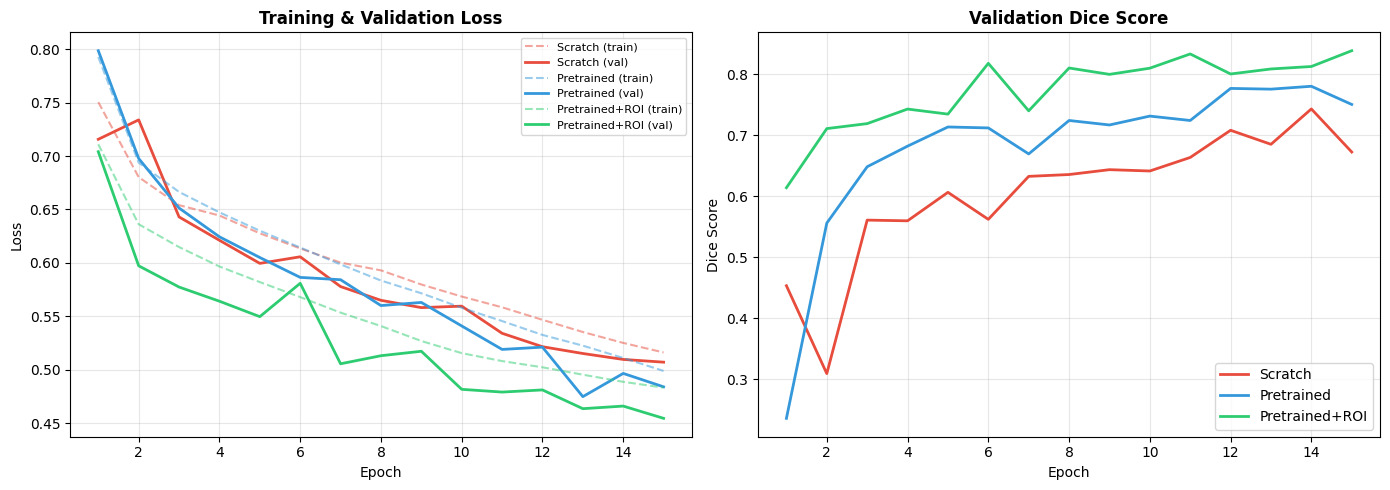

In [36]:
# =========================================
#  LEARNING CURVES
# =========================================
print("=" * 50)
print(" LEARNING CURVES")
print("=" * 50)

histories = [hist_scratch, hist_pretr, hist_roi]
names = ["Scratch", "Pretrained", "Pretrained+ROI"]
colors = ['#e74c3c', '#3498db', '#2ecc71']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for hist, name, color in zip(histories, names, colors):
    axes[0].plot(hist["epoch"], hist["train_loss"], '--', color=color, alpha=0.5, label=f'{name} (train)')
    axes[0].plot(hist["epoch"], hist["val_loss"], '-', color=color, linewidth=2, label=f'{name} (val)')
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss", fontweight='bold')
axes[0].legend(loc='upper right', fontsize=8); axes[0].grid(True, alpha=0.3)

for hist, name, color in zip(histories, names, colors):
    axes[1].plot(hist["epoch"], hist["val_dice"], '-', color=color, linewidth=2, label=name)
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Dice Score")
axes[1].set_title("Validation Dice Score", fontweight='bold')
axes[1].legend(loc='lower right'); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

 TEST SET RESULTS


,Method,Dice %,IoU %
0,Scratch,65.567633,55.199478
1,Pretrained,71.153585,60.329574
2,Pretrained+ROI,75.957171,65.749039



 Improvement over Scratch baseline:
   Pretrained:     +8.5% Dice | +9.3% IoU
   Pretrained+ROI: +15.8% Dice | +19.1% IoU


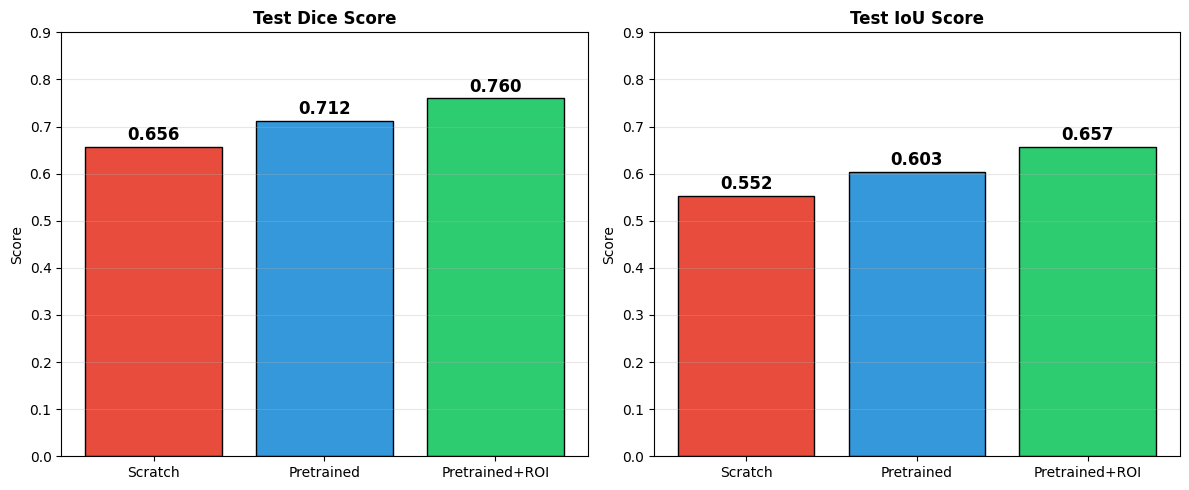

In [38]:
# =========================================
#  TEST SET RESULTS
# =========================================
print("=" * 50)
print(" TEST SET RESULTS")
print("=" * 50)

names = ["Scratch", "Pretrained", "Pretrained+ROI"]
colors = ['#e74c3c', '#3498db', '#2ecc71']

# Table
results_df = pd.DataFrame({
    "Method": names,
    "Dice %": [res_scratch[0] * 100, res_pretr[0] * 100, res_roi[0] * 100],
    "IoU %": [res_scratch[1] * 100, res_pretr[1] * 100, res_roi[1] * 100]
})
display(results_df)

# Improvement
print("\n Improvement over Scratch baseline:")
print(f"   Pretrained:     +{((res_pretr[0] - res_scratch[0]) / res_scratch[0]) * 100:.1f}% Dice | +{((res_pretr[1] - res_scratch[1]) / res_scratch[1]) * 100:.1f}% IoU")
print(f"   Pretrained+ROI: +{((res_roi[0] - res_scratch[0]) / res_scratch[0]) * 100:.1f}% Dice | +{((res_roi[1] - res_scratch[1]) / res_scratch[1]) * 100:.1f}% IoU")

# Bar plots
dice = [res_scratch[0], res_pretr[0], res_roi[0]]
iou = [res_scratch[1], res_pretr[1], res_roi[1]]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bars1 = axes[0].bar(names, dice, color=colors, edgecolor='black')
axes[0].set_ylabel('Score'); axes[0].set_title('Test Dice Score', fontweight='bold')
axes[0].set_ylim(0, 0.9); axes[0].grid(True, axis='y', alpha=0.3)
for bar in bars1:
    axes[0].annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     xytext=(0, 5), textcoords="offset points", ha='center', fontsize=12, fontweight='bold')

bars2 = axes[1].bar(names, iou, color=colors, edgecolor='black')
axes[1].set_ylabel('Score'); axes[1].set_title('Test IoU Score', fontweight='bold')
axes[1].set_ylim(0, 0.9); axes[1].grid(True, axis='y', alpha=0.3)
for bar in bars2:
    axes[1].annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     xytext=(0, 5), textcoords="offset points", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

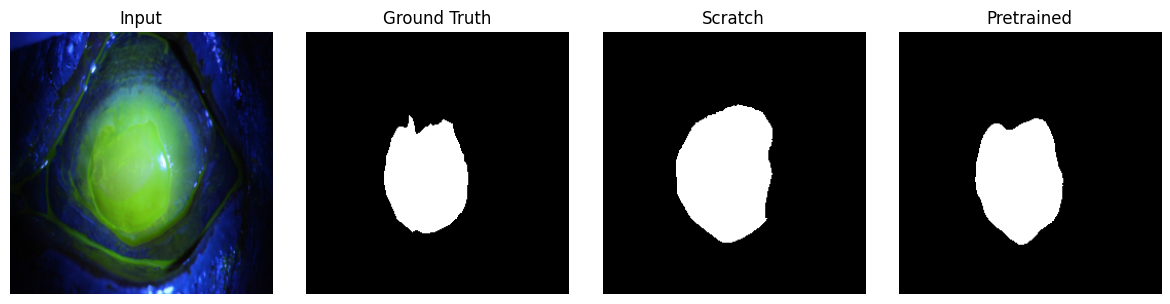

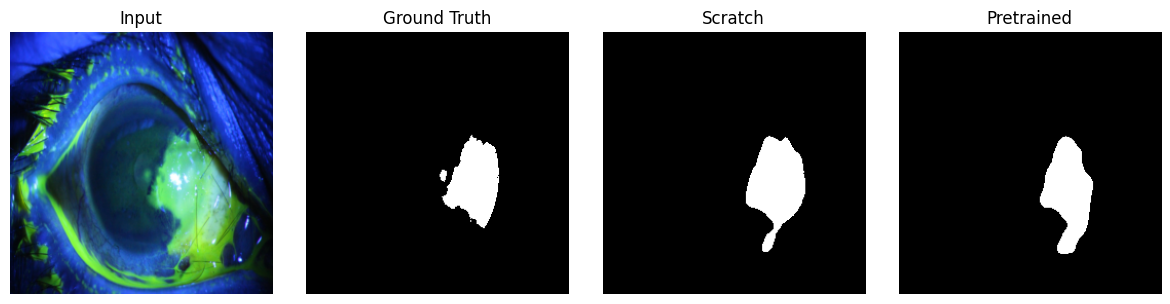

In [25]:
# =========================================
#  Visual Comparison: Scratch vs Pretrained
# =========================================
@torch.no_grad()
def show_scratch_vs_pretrained(n=2):
    """Compare Scratch vs Pretrained predictions."""
    ds = UlcerSegDataset(df, "test", use_roi=False, train_aug=False)
    model_scratch.eval()
    model_pretr.eval()

    random.seed(42)  # Reproducible selection
    indices = random.sample(range(len(ds)), n)

    for idx in indices:
        x, y = ds[idx]
        xx = x.unsqueeze(0).to(DEVICE)

        pred_scratch = (torch.sigmoid(F.interpolate(model_scratch(xx), size=y.shape[-2:], mode="bilinear"))[0,0].cpu().numpy() > 0.5).astype(np.uint8)
        pred_pretr = (torch.sigmoid(F.interpolate(model_pretr(xx), size=y.shape[-2:], mode="bilinear"))[0,0].cpu().numpy() > 0.5).astype(np.uint8)
        gt = y[0].numpy().astype(np.uint8)
        img = (x * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).numpy()

        fig, axes = plt.subplots(1, 4, figsize=(12, 3))
        axes[0].imshow(img); axes[0].set_title("Input"); axes[0].axis("off")
        axes[1].imshow(gt, cmap="gray"); axes[1].set_title("Ground Truth"); axes[1].axis("off")
        axes[2].imshow(pred_scratch, cmap="gray"); axes[2].set_title("Scratch"); axes[2].axis("off")
        axes[3].imshow(pred_pretr, cmap="gray"); axes[3].set_title("Pretrained"); axes[3].axis("off")
        plt.tight_layout()
        plt.show()

show_scratch_vs_pretrained(2)